# Imports

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime

# Variables and Utils

In [2]:
ip_client = "10.1.0.2"
ip_server = "10.1.0.3"
ip_orchestrator = "10.1.0.255"
ip_seperator = "92.60.39.199"

allPreKnownServers = [ip_client, ip_server]
print(allPreKnownServers)

def to_human_readable(size):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    return "{0} {1}".format(size, mem[n])

['10.1.0.2', '10.1.0.3']


In [3]:

# Get Data
from google.cloud import bigquery
from google.cloud import storage
from google.oauth2 import service_account
from google.cloud.bigquery.job import ExtractJobConfig
credentials = service_account.Credentials.from_service_account_file(
    '../infrastructure/credentials.json')

project_id = '932771810925' # Our project ID

client = bigquery.Client(credentials=credentials)
bucket_name = 'syncmesh-log-bucket'
project = "dspj-315716"
dataset_id = "syncmesh"
today = datetime.datetime.today()
table_id = f"compute_googleapis_com_vpc_flows_{today.strftime('%Y%m%d')}"
# table_id = 'compute_googleapis_com_vpc_flows_20210719'
blob_name = "export.log"

destination_uri = "gs://{}/{}".format(bucket_name, blob_name)
dataset_ref = bigquery.DatasetReference(project, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_conf = ExtractJobConfig()
extract_conf.compression = 'NONE'
extract_conf.destination_format = 'NEWLINE_DELIMITED_JSON'

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
    job_config=extract_conf
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
)


storage_client = storage.Client(credentials=credentials)

bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.download_to_filename("export.log")

print(
    "Blob {} downloaded successfully ".format(
        blob_name
    )
)

Exported dspj-315716:syncmesh.compute_googleapis_com_vpc_flows_20210720 to gs://syncmesh-log-bucket/export.log
Blob export.log downloaded successfully 


# Data Preparation

In [4]:
df = pd.read_json('export.log', lines = True)
df = (pd.DataFrame(df['jsonPayload'].values.tolist())
        .add_prefix('jsonPayload.')
        .join(df.drop('jsonPayload', 1)))
df = (pd.DataFrame(df['jsonPayload.connection'].values.tolist())
        .add_prefix('jsonPayload.connection.')
        .join(df.drop('jsonPayload.connection', 1)))
df = df.dropna(subset=['jsonPayload.rtt_msec'])
df = df.astype({
    'jsonPayload.bytes_sent': 'int32',
    'jsonPayload.rtt_msec': 'int32'
    })
df = df.astype({'jsonPayload.connection.src_port': 'int32'})
df = df.astype({'jsonPayload.connection.dest_port': 'int32'})
df.set_index('timestamp', inplace=True)
orig_df = df
# Filter Entries for internal Traffic which is where the Benchmark Traffic is
df = df[df["jsonPayload.connection.src_ip"].str.contains(r'^10\.')]
df = df[df["jsonPayload.connection.dest_ip"].str.contains(r'^10\.')]

# TODO: Filter Entries for port specific traffic

sep_df = orig_df[orig_df["jsonPayload.connection.src_ip"].isin([ip_seperator, ip_orchestrator])]
sep_df = orig_df[orig_df["jsonPayload.connection.dest_ip"].isin([ip_seperator, ip_orchestrator])]
# df = df[df["jsonPayload.connection.dest_ip"]]
print(sep_df["jsonPayload.connection.src_port"].head())

nodes = list(dict.fromkeys(df["jsonPayload.connection.dest_ip"].unique().tolist() + df["jsonPayload.connection.src_ip"].unique().tolist()))
nodes = [node for node in nodes if node not in [ip_client, ip_server, ip_orchestrator]]
# print(nodes)

# Print Table
# df[["jsonPayload.connection.src_ip", "jsonPayload.connection.src_port", "jsonPayload.connection.dest_ip", "jsonPayload.bytes_sent", "jsonPayload.rtt_msec"]].unique()
# df.info()
# df.head()


timestamp
2021-07-20 00:06:59.647154+00:00    443
2021-07-20 00:06:59.647154+00:00    443
2021-07-20 00:06:59.647154+00:00    443
2021-07-20 00:06:59.647154+00:00    443
2021-07-20 00:11:00.214475+00:00    443
Name: jsonPayload.connection.src_port, dtype: int32


In [5]:
fromClient = df[df['jsonPayload.connection.src_ip']==ip_client]
toServer = df[df['jsonPayload.connection.dest_ip']==ip_server]


fromClientDataset = {}
toServerDataset = {}
betweenNodesDataset = {}
for node in nodes: 
    fromClientDataset[node] = fromClient[fromClient['jsonPayload.connection.dest_ip']==node]

nodeCombinations = list(itertools.combinations(nodes, r=2))
for combination in nodeCombinations: 
    # Use both src_ip and dest_ip as they are not request related
    fromNode = df[df['jsonPayload.connection.src_ip'].isin(combination)]
    # fromAnyNode = df[df["jsonPayload.connection.src_ip"].isin(nodes)]
    betweenNodesDataset["between " + combination[0] + " and " + combination[1]] = fromNode[fromNode['jsonPayload.connection.dest_ip'].isin(combination)]

for node in nodes: 
    toServerDataset[node] = toServer[toServer['jsonPayload.connection.src_ip']==node]



# print(nodeCombinations)
# toServer.head()
# toServerDataset["10.2.0.12"].head()
# betweenNodesDataset['between 10.1.0.11 and 10.3.0.13'].info()
# fromClientDataset

# Results

## General

Text(0.5, 0, 'Round Trip Time (msec)')

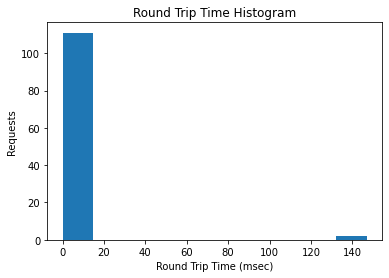

In [6]:
fig, ax = plt.subplots()
remove0 = df[df['jsonPayload.bytes_sent']!=0]
ax.hist(remove0['jsonPayload.rtt_msec'])
ax.set_title("Round Trip Time Histogram")
ax.set_ylabel("Requests")
ax.set_xlabel("Round Trip Time (msec)")

## Case: Baseline (Central Mongo)

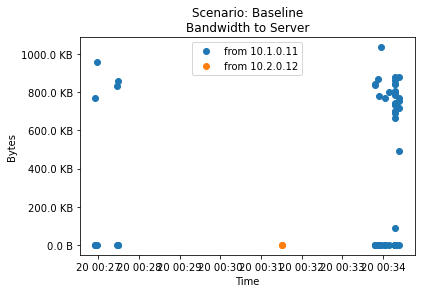

In [14]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label="from " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Baseline\nBandwidth to Server')
ax.set_ylabel("Bytes")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.set_xlabel("Time")
ax.legend()
fig.savefig("out/bandwidth_to_server.png")
plt.show()

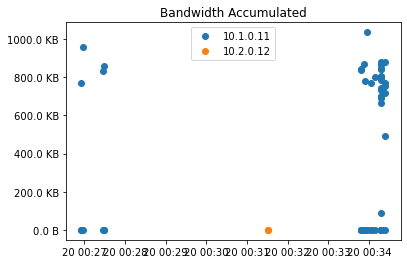

In [15]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Bandwidth Accumulated')
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend()
plt.show()

## Case: Syncmesh

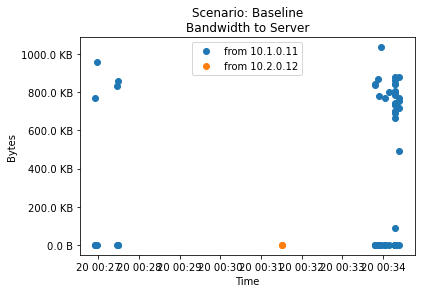

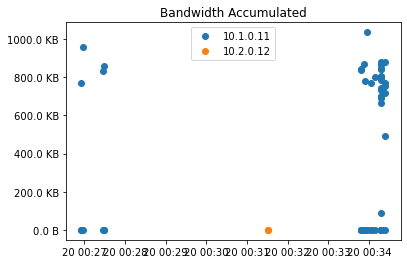

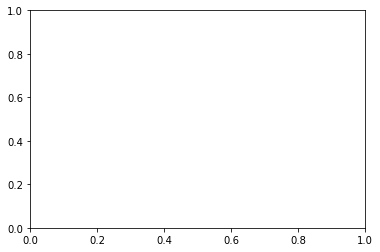

In [9]:
fig, ax = plt.subplots()
# plot histogram
binwidth = 10

# ax.hist(fromClientTo4['jsonPayload.bytes_sent'], bins=range(min(fromClientTo4['jsonPayload.bytes_sent']), max(fromClientTo4['jsonPayload.bytes_sent']) + binwidth, binwidth))
# ax.set_title("Package Size Histogram for Client to 4")

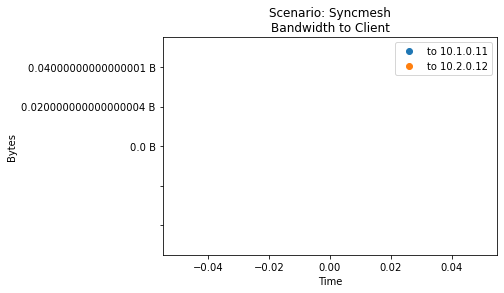

In [10]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in fromClientDataset: 
    ax.plot(fromClientDataset[key].index, fromClientDataset[key]["jsonPayload.bytes_sent"], label="to " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth to Client')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend()
# fig.savefig("out/bandwidth_from_client.png")
plt.show()

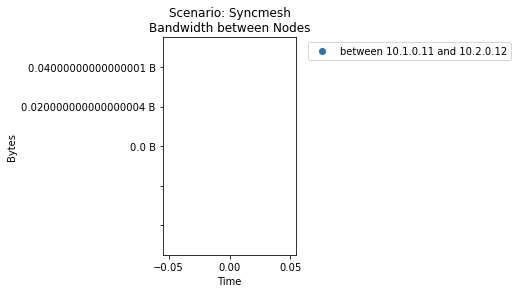

In [11]:
fig, ax = plt.subplots()



# ax.set_ylim(0,500)
for key in betweenNodesDataset: 
    ax.plot(betweenNodesDataset[key].index, betweenNodesDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

# Comparison

[0, 0, 0]


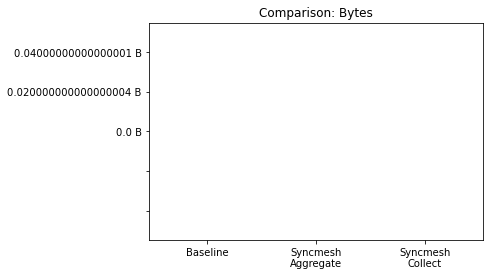

In [12]:
timedfbaseline = df.loc['2021-7-7 16:10':'2021-7-7 16:14']

baselineAggregateBytes = timedfbaseline["jsonPayload.bytes_sent"].sum()
baselineAggregateRTT = timedfbaseline["jsonPayload.rtt_msec"].sum()

timedfaggregate = df.loc['2021-7-7 16:06':'2021-7-7 16:08']

syncmeshAggregateBytes = timedfaggregate["jsonPayload.bytes_sent"].sum()
syncmeshAggregateRTT = timedfaggregate["jsonPayload.rtt_msec"].sum()

timedfcollect = df.loc['2021-7-7 16:03':'2021-7-7 16:05']

syncmeshCollectBytes = timedfcollect["jsonPayload.bytes_sent"].sum()
syncmeshCollectRTT = timedfcollect["jsonPayload.rtt_msec"].sum()

# timedfbaseline.info()

fig, ax = plt.subplots()
cases = ['Baseline', 'Syncmesh\nAggregate', 'Syncmesh\nCollect']
values = [baselineAggregateBytes, syncmeshAggregateBytes, syncmeshCollectBytes]
print(values)
ax.bar(cases,values)
ax.set_title('Comparison: Bytes')
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/comparison.png")
plt.show()

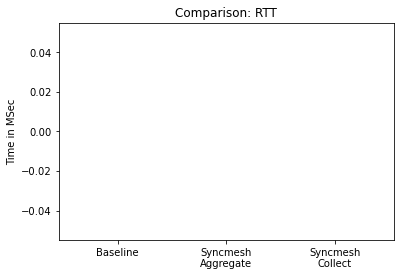

In [13]:
fig, ax = plt.subplots()
cases = ['Baseline', 'Syncmesh\nAggregate', 'Syncmesh\nCollect']
values = [baselineAggregateRTT, syncmeshAggregateRTT, syncmeshCollectRTT]
ax.bar(cases,values)
ax.set_title('Comparison: RTT')
ax.set_ylabel("Time in MSec")
# ax.set_xlabel("Time")
fig.savefig("out/comparison_rtt.png")
plt.show()